In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import pandas as pd
import numpy as np
from scipy import optimize
import random
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import csv
import time
import integrator
import atm.core
import atm.jobs as jr
import re
import seaborn as sns

In [5]:
class LammpsCalculations:
    def solid(self, Tequil: float):
        import random
        seed = random.randint(1,2**31-1)
        return f"""\

#INITIALIZATION

units           metal
atom_style      atomic
boundary        p p p

#SYSTEM DEFINITION

lattice fcc 4.046 orient x 1 0 0 orient y 0 1 0 orient z 0 0 1

#lattice diamond 5.615795

region          simbox block 0 8 0 8 0 16
create_box      1 simbox
create_atoms    1 region simbox

#set atom * type/fraction 2 1.0 777
#mass  1  28.085   # Si
#mass  2  72.630   # Ge

mass            1 26.982

#FORCE FIELD

pair_style     eam/fs
pair_coeff     * * Al_mm.eam.fs Al

#pair_style      mlip mlip.ini
#pair_coeff      * *

#RUN MOLECULAR DYNAMICS

timestep        0.001 # 1 fs

fix             1 all npt temp {Tequil} {Tequil} 0.1 iso 0.0 0.0 0.1

velocity        all create {Tequil} {seed} rot yes dist gaussian


variable        peatom equal pe/atoms
variable        volatom equal vol/atoms
variable        myTemp equal temp


thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

run             10000

fix ave_pe all ave/time 1000 5 15000 v_peatom

thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

variable p equal "f_ave_pe" 

run             5000

print    "MYOUTCOME: $p"
"""
    
    def liquid(self, Tliq: float):
        import random
        seed = random.randint(1,2**31-1)
        return f"""\
    
#INITIALIZATION

units           metal
atom_style      atomic
boundary        p p p

#SYSTEM DEFINITION

lattice fcc 4.046 orient x 1 0 0 orient y 0 1 0 orient z 0 0 1

#lattice diamond 5.615795

region          simbox block 0 8 0 8 0 16
create_box      1 simbox
create_atoms    1 region simbox

#set atom * type/fraction 2 1.0 777
#mass  1  28.085   # Si
#mass  2  72.630   # Ge

mass            1 26.982

#FORCE FIELD

pair_style     eam/fs
pair_coeff     * * Al_mm.eam.fs Al

#pair_style      mlip mlip.ini
#pair_coeff      * *

#RUN MOLECULAR DYNAMICS

variable        Tequil index {Tliq * 1.5}

timestep        0.001 # 1 fs

fix             1 all npt temp ${{Tequil}} ${{Tequil}} 0.1 iso 0.0 0.0 0.1

velocity        all create ${{Tequil}} {seed} rot yes dist gaussian


variable        peatom equal pe/atoms
variable        volatom equal vol/atoms
variable        myTemp equal temp


thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

run             15000

fix             1 all npt temp {Tliq} {Tliq} 0.1 aniso 0.0 0.0 0.1


thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

run             20000

fix ave_pe all ave/time 1000 10 45000 v_peatom

thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

variable p equal "f_ave_pe" 

run             10000

print    "MYOUTCOME: $p"
"""
    
    def error(self, w, Temp, points):
        sum = 0
        for i in range(len(points)):
            sum += (points[i] - (w[1] + w[0]*Temp[i]))**2
        return sum
    
    def solid_line(self, T_melt):
        i = 0
        Temp_solid = np.arange(T_melt*0.8,T_melt*0.6,-T_melt*0.1)
        points_solid = np.zeros(len(Temp_solid))
        
        with open('Al_mm.eam.fs', 'r') as f:
            pot = f.read()
            
        job_id_array = [jr.submit_job(jr.job.GenericLammps(self.solid(T), extra_in_files = {'Al_mm.eam.fs':pot}), metadata = {'needs_dir': True, 'n_cores_min': 10, 'n_cores_max': 128}) for T in Temp_solid]
        for job_id in job_id_array:
            jr.wait_for_job(job_id)
            result = str(jr.get_job_result(job_id))
            match = re.search('MYOUTCOME: (-\d*.\d*)', result, re.MULTILINE)
            point = float(match.group(1)) if match is not None else None
            points_solid[i] = point
            #print("Job", job_id, "done", point, i)
            i += 1
        print('Temperatures for solid line:', Temp_solid)
        print('Potential energies of solid phase:', points_solid)
        bnds = ((-1, 1), (-10, 10))
        x0 = [0,0]
        res_solid = optimize.minimize(self.error, x0, args=(Temp_solid, points_solid), method='L-BFGS-B', bounds=bnds)
        return res_solid.x[0], res_solid.x[1]
    
    def liquid_line(self, T_melt):
        i = 0
        Temp_liquid = np.arange(T_melt*1.2, T_melt*1.4, T_melt*0.1)
        points_liquid = np.zeros(len(Temp_liquid))
        
        with open('Al_mm.eam.fs', 'r') as f:
            pot = f.read()
            
        job_id_array = [jr.submit_job(jr.job.GenericLammps(self.liquid(T), extra_in_files = {'Al_mm.eam.fs':pot}), metadata = {'needs_dir': True, 'n_cores_min': 10, 'n_cores_max': 128}) for T in Temp_liquid]
        for job_id in job_id_array:
            jr.wait_for_job(job_id)
            result = str(jr.get_job_result(job_id))
            match = re.search('MYOUTCOME: (-\d*.\d*)', result, re.MULTILINE)
            point = float(match.group(1)) if match is not None else None
            points_liquid[i] = point
            i += 1
            #print("Job", job_id, "done", point, i)
        print('Temperatures for liquid line:', Temp_liquid)
        print('Potential energies of liquid phase:', points_liquid)
        bnds = ((-1, 1), (-10, 10))
        x0 = [0,0]
        res_liquid = optimize.minimize(self.error, x0, args=(Temp_liquid, points_liquid), method='L-BFGS-B', bounds=bnds)
        return res_liquid.x[0], res_liquid.x[1]
    
    def my_lammps_script(self, Tequil: float, L: int, ksol: float, bsol: float, kliq: float, bliq: float):
        import random
        seed = random.randint(1,2**31-1)
        return f"""\

units           metal
atom_style      atomic
boundary        p p p

#SYSTEM DEFINITION SOLID+LIQUID

lattice fcc 4.046 orient x 1 0 0 orient y 0 1 0 orient z 0 0 1

#lattice diamond 5.615795

region          solid block 0 {L} 0 {L} 0 {L-0.25}
region          liquid block 0 {L} 0 {L} {L-0.25} {2*L}
region          sol_liq union 2 solid liquid

create_box      1 sol_liq
create_atoms    1 region sol_liq

group           solid region solid
group           liquid region liquid
group           sol_liq region sol_liq

#set atom * type/fraction 2 1.0 777
#mass  1  28.085   # Si
#mass  2  72.630   # Ge

mass            1 26.982 #Al

#FORCE FIELD

pair_style      eam/fs
pair_coeff      * * Al_mm.eam.fs Al

#pair_style      mlip mlip.ini
#pair_coeff      * *

#RUN MOLECULAR DYNAMICS

variable        Tliq equal {1.5*Tequil}

variable        ensol equal {ksol}*{Tequil}+{bsol}       #eam
variable        enliq equal {kliq}*{Tequil}+{bliq}       #eam

variable        ensolnew equal "(v_ensol*7 + v_enliq)/8"
variable        enliqnew equal "(v_enliq*7 + v_ensol)/8"

#variable       seed index 987654321

velocity        all create {Tequil} {seed} rot yes dist gaussian

variable        peatom equal pe/atoms
variable        volatom equal vol/atoms
variable        myStep equal step
variable        myTemp equal temp

#SIMULATION PARAMETERS 1 SOLID+LIQUID Tm iso

timestep        0.001 # 1 fs

fix             1 sol_liq npt temp {Tequil} {Tequil} 0.1 iso 0.0 0.0 0.1

thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

run             10000

#SIMULATION PARAMETERS 2 LIQUID Tm*2 iso

fix             1 liquid npt temp ${{Tliq}} ${{Tliq}} 0.1 iso 0.0 0.0 0.1

thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

run             10000


#SIMULATION PARAMETERS 3 SOLID+LIQUID Tm aniso

fix             1 sol_liq npt temp {Tequil} {Tequil} 0.1 aniso 0.0 0.0 0.1

thermo_style    custom step temp etotal v_peatom v_volatom
thermo 1000

run 5000 #balancing run

label loop
variable i loop 1000
run 1000
if "(${{peatom}} < ${{ensolnew}})" then "print 'MYOUTCOME: solid'" &
   "jump SELF break" &
elif "(${{peatom}} > ${{enliqnew}})" &
     "print 'MYOUTCOME: liquid'" &
     "jump SELF break"
next i
jump SELF loop
label break
print "ALL DONE"
"""
    
    def data_append(self, T, L, ksol, bsol, kliq, bliq):
        if L <= 3:
            k = 10
        elif L == 4:
            k = 5
        elif L == 5:
            k = 2
        else:
            k = 1
        sol = 0
        liq = 0
        
        with open('Al_mm.eam.fs', 'r') as f:
            pot = f.read()
            
        job_id_array = [jr.submit_job(jr.job.GenericLammps(self.my_lammps_script(T, L, ksol, bsol, kliq, bliq), extra_in_files = {'Al_mm.eam.fs':pot}), metadata = {'needs_dir': True, 'n_cores_min': 10, 'n_cores_max': 128}) for i in range(k)]
        for job_id in job_id_array:
            jr.wait_for_job(job_id)
            result = str(jr.get_job_result(job_id))
            match = re.search('MYOUTCOME: (\w*)', result, re.MULTILINE)
            phase = match.group(1) if match is not None else None
            if phase == "solid":
                sol += 1
            else:
                liq += 1
        return L, T, sol, liq
    
    def temp_sl(self, L , T, sol, liq, my_dict):
        if L not in my_dict:
            my_dict.update({L: {T: [sol, liq]}})

        elif L in my_dict:
            if T not in my_dict[L]:
                my_dict[L].update({T: [sol, liq]})
            elif T in my_dict[L]:
                my_dict[L][T][0] += sol
                my_dict[L][T][1] += liq
        return my_dict

In [6]:
class GaussianProcess():
    #kernel
    def k_gauss(self, N_train, N_test, thN, sig_f):
        k = np.zeros((len(N_train),len(N_test)))
        for i in range(len(N_train)):
            for j in range(len(N_test)):
                k[i][j] = sig_f**2*np.exp(-(1/N_train[i] - 1/N_test[j])**2*thN**2/2)
        return k
    
    #kernel for test points
    def k_test_gauss(self, N_train, N_test, thN, sig_f):
        k_test = np.zeros((len(N_train),1))
        for i in range(len(N_train)):
            k_test[i] = sig_f**2*np.exp(-(1/N_train[i] - 1/N_test)**2*thN**2/2)
        return k_test
    
    #log likelihood
    def log_p_gauss(self, params, N_train, T_train, var_temp):
        thN, sig_f = params
        A = self.k_gauss(N_train,N_train,thN,sig_f) + var_temp*np.identity(len(N_train))
        A_inv = np.linalg.inv(A)
        log_p = ((T_train.dot(A_inv)).dot(T_train.reshape(-1,1)) + np.log(np.linalg.det(A)) + ((thN-30)/30)**2 + ((sig_f-3000)/3000)**2 + len(N_train)*np.log(2*np.pi))/2
        return log_p
    
    #meaning value of GP regression
    def f_mean(self, N_train, T_train, N_test, var_temp, thN, sig_f):
        A = self.k_gauss(N_train,N_train,thN, sig_f) + var_temp*np.identity(len(N_train))
        A_inv = np.linalg.inv(A)
        f_star = self.k_gauss(N_test,N_train,thN, sig_f).dot(A_inv).dot(T_train.reshape(-1,1))

        return f_star
    
    #variance of the value
    def var(self, N_train, N_test, var_temp, thN, sig_f):
        Var_f_star = np.zeros((len(N_test), 1))
        A = self.k_gauss(N_train,N_train,thN, sig_f) + var_temp*np.identity(len(N_train))
        A_inv = np.linalg.inv(A)
        for i in range(len(N_test)):
            Var_f_star[i] = sig_f**2*np.exp(-(1/N_test[i] - 1/N_test[i])**2*thN**2/2) - (self.k_test_gauss(N_train,N_test[i],thN,sig_f).T).dot(A_inv).dot(self.k_test_gauss(N_train,N_test[i],thN,sig_f))
        return Var_f_star
    
    #derivation of variance
    def dV(self, N_train, N_test, var_temp, thN, sig_f):
        B = self.k_gauss(N_train,N_train,thN, sig_f) + var_temp*np.identity(len(N_train))
        B_inv = np.linalg.inv(B)
        dV = np.zeros((len(N_train), len(N_train)))
        for i in range(len(N_train)):
            a_ii = np.zeros((len(N_train)))
            a_ii[i] = 1
            dV[i][i] = -(self.k_test_gauss(N_train,N_test,thN,sig_f).T).dot(B_inv).dot(var_temp*np.identity(len(N_train))).dot(a_ii*np.identity(len(N_train))).dot(var_temp*np.identity(len(N_train))).dot(B_inv).dot(self.k_test_gauss(N_train,N_test,thN,sig_f))
        return dV
    
    #!!!!!!!!!!
    #points for which L that we need to make MD
    def add_L(self, L_array, N_array, L_train, N_train, N_test, var_temp, s_0, thN, sig_f):
        var = np.full(len(L_array), 1e+6)
        sig = 1.5*s_0/N_array
        for i in range(len(L_train)):
            for j in range(len(L_array)):
                if L_array[j] == L_train[i]:
                    var[j] = var_temp[i]
                    sig[j] = s_0/N_train[i]

        v = -1*self.dV(N_array, N_test, var, thN, sig_f)
        dVar_defforts = np.zeros((len(N_array)))
        #!!!!!!!!!!!
        for j in range(len(N_array)):
            #if L_array[j] not in L_train and L_array[j] <= 6:
            #if L_array[j] != 3 and L_array[j] < 5:
            dVar_defforts[j] = v[j][j]/(L_array[j]**7*sig[j]**2)
        print('L_array:',L_array)
        print('dVar_defforts', dVar_defforts)
        return L_array[np.argmax(dVar_defforts)].round(0), np.argmax(dVar_defforts), N_array[np.argmax(dVar_defforts)].round(0)
    
    #temperature from T_melt - 1.6*sigma < T_melt < T_melt - 0.6*sigma interval that we need to add for L
    def T_low(self, T_melt, sigma):
        k = 13
        T_low = 2**k
        while True:
            if T_low > T_melt-0.6*sigma:
                T_low -= 2**(k-1)
                k -= 1
            elif T_low < T_melt-1.6*sigma:
                T_low += 2**(k-1)
                k -= 1
            else:
                break
        return T_low

    def T_high(self, T_melt, sigma):
        k = 13
        T_high = 2**k
        while True:
            if T_high > T_melt+1.6*sigma:
                T_high -= 2**(k-1)
                k -= 1
            elif T_high < T_melt+0.6*sigma:
                T_high += 2**(k-1)
                k -= 1
            else:
                break
        return T_high
    
    def sig0(self, s_0, N_train, L_train, bayes):
        res = 0
        for i in range(len(N_train)):
            result = bayes.T_melt(L_train[i], float(s_0/N_train[i]), 1e-5)
            res += result[0]
        return -res

In [7]:
class MainClass:
    def __init__(self, Tmelt, structure):
        self.L_array = np.arange(13)
        self.Tmelt = Tmelt
        self.structure = structure
        if structure == 'fcc':
            self.N_array = self.L_array**3*8
        elif structure == 'diamond':
            self.N_array = self.L_array**3*16
        elif structure == 'bcc':
            self.N_array = self.L_array**3*4
        elif structure == 'sc':
            self.N_array = self.L_array**3
        else:
            print('I do not know this :(')
            
        while self.N_array[0] < 100:
            self.N_array = np.delete(self.N_array, 0)
            self.L_array = np.delete(self.L_array, 0)  

    def WriteResults(self, status:str):
        if hasattr(self,'bsol') and hasattr(self,'ksol') and hasattr(self,'bliq') and hasattr(self,'kliq'):
            solid_liquid_line = f'''\
<h2><big>Potential energies of solid and liquid</big></h2>
<p><img src="lines.png" alt="solid/liquid potential energy graphs">
</p>
'''
        else:
            solid_liquid_line = ''
            
        #qwe
        if hasattr(self,'T_needed') and hasattr(self,'var_needed'):
            result_at_inf = f'''\
<p><b><big><big>Melting point:</b> {self.T_needed[0][0].round(1)} &pm; {self.var_needed[0][0].round(1)}</big></big></p>
'''
            gp_str = f'''\
<h2><big>Melting point convergence graph</big></h2>
<p><img src="GP.png" alt="Melting point convergence graph">
</p>
'''
        else:
            result_at_inf = ''
            gp_str = ''
            
        html_str = f'''\
<!DOCTYPE html>
<html>
<title>Melting point for Al</title>
<body>

<h1><big>Melting point for Al EAM</big></h1>
{result_at_inf}
<p><b><big><big>Status:</b> {status}</big></big></p>

{gp_str}

{solid_liquid_line}

</body>
</html>
'''
        with open('index.html','w') as f:
            f.write(html_str)
    
    def Lines(self, LAMMPS, Tmelt=None):
        if Tmelt is None:
            Tmelt = self.Tmelt
        
        self.WriteResults(status = "Solid line is being calculated")
        ksol, bsol = LAMMPS.solid_line(Tmelt)
        print('ksol*T + bsol:', 'ksol = ', ksol, ',' , 'bsol = ', bsol)
        
        self.WriteResults(status = "Liquid line is being calculated")
        kliq, bliq = LAMMPS.liquid_line(Tmelt)
        print('kliq*T + bliq:', 'kliq = ', kliq, ',' , 'bliq = ', bliq)
        
        self.ksol, self.bsol, self.kliq, self.bliq = ksol, bsol, kliq, bliq
        
        plt.figure(figsize=(8, 5))
        x = np.linspace(0.6*Tmelt, 1.4*Tmelt, 1000)
        y = ksol*x+bsol
        t = kliq*x+bliq
        plt.plot(x,y, label='Potential energy of solid phase',  color='blue')
        plt.plot(x,t, label='Potential energy of liquid phase', color='indianred')
        plt.legend()
        plt.grid()
        plt.xlabel('Temperature, K')
        plt.ylabel('Potential energy, eV')
        plt.title('Al EAM')
        plt.savefig('lines.png', facecolor='white',dpi=200)
        plt.show()
        
        return ksol, bsol, kliq, bliq

    def FirstAdd(self, GP, LAMMPS, melt, name, sig_start, ksol, bsol, kliq, bliq, Tmelt=None):
        if Tmelt is None:
            Tmelt = self.Tmelt
        Dict_new = {}
        
        T1_start = GP.T_low(Tmelt, sig_start)
        print('Temperatures of MD for the first L:')
        print('T1 =', T1_start)
        T2_start = GP.T_high(Tmelt, sig_start)
        print('T2 =', T2_start)
        self.WriteResults(status = f"Calculations for the first point L = {self.L_array[0]} started")
            
        L1, T1, sol1, liq1 = LAMMPS.data_append(T1_start, self.L_array[0], ksol, bsol, kliq, bliq)
        print('Results: L, T, number of solid outcomes, number of liquid outcomes')
        print(L1, T1, sol1, liq1)
        L2, T2, sol2, liq2 = LAMMPS.data_append(T2_start, self.L_array[0], ksol, bsol, kliq, bliq)
        print(L2, T2, sol2, liq2)

        while True:
            if sol1 == 0 and sol2 == 0:
                Tmelt = Tmelt - 2.5*sig_start
                L2, T2, sol2, liq2 = L1, T1, sol1, liq1
                T1 = GP.T_low(Tmelt, sig_start)
                print('low:',T1,T2)
                L1, T1, sol1, liq1 = LAMMPS.data_append(T1, self.L_array[0], ksol, bsol, kliq, bliq)
            elif liq1 == 0 and liq2 == 0:
                Tmelt = Tmelt + 2.5*sig_start
                L1, T1, sol1, liq1 = L2, T2, sol2, liq2
                T2 = GP.T_high(Tmelt, sig_start)
                print('high:',T1,T2)
                L2, T2, sol2, liq2 = LAMMPS.data_append(T2, self.L_array[0], ksol, bsol, kliq, bliq)
            else:
                print('okay')
                break

        melt.AddDataPoint(L1, T1, sol1, liq1)
        LAMMPS.temp_sl(L1, T1, sol1, liq1, Dict_new)

        melt.AddDataPoint(L2, T2, sol2, liq2)
        LAMMPS.temp_sl(L2, T2, sol2, liq2, Dict_new)

        with open(name, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([L1, T1, sol1, liq1])
            writer.writerow([L2, T2, sol2, liq2])
        return Dict_new

    def FirstRead(self, LAMMPS, melt, name):
        Dict_new = {}
        data = pd.read_csv(name, header=None)
        for i in range(len(data)):
            melt.AddDataPoint(data.iloc[i,0], data.iloc[i,1], data.iloc[i,2], data.iloc[i,3])
            LAMMPS.temp_sl(data.iloc[i,0], data.iloc[i,1], data.iloc[i,2], data.iloc[i,3], Dict_new)
        return Dict_new
    
    def MainFunc(self,name):
        Tmelt = self.Tmelt
        L_array = self.L_array
        N_array = self.N_array
        
        L_train = np.array([L_array[0]])
        N_train = np.array([N_array[0]])
        var_T_start = np.array([1e+6])
        s_0 = random.randint(1000,10000)
        sig_start = s_0/N_train
        var_sig_start = np.array([1e+6])
        N_star = np.array([np.inf])
        N_test = np.linspace(200, 60000, 10000)

        sig_dict = {}
        log_likelihood_dict = {}
        N_train_dict = {}
        T_train_dict = {}

        melt = integrator.Bayesian()
        GP = GaussianProcess()
        LAMMPS = LammpsCalculations()
        
        ksol, bsol, kliq, bliq = self.Lines(LAMMPS, Tmelt)
        #ksol, bsol, kliq, bliq = 0.00016887229916094434, -3.426957680188676, 0.00018372423139186361, -3.3184970819804107
        
        Dict_new = self.FirstAdd(GP, LAMMPS, melt, name, sig_start, ksol, bsol, kliq, bliq, Tmelt)
        #Dict_new = self.FirstRead(LAMMPS, melt, name)
        print('MD data:')
        print(Dict_new)

        tic = time.perf_counter()
        self.WriteResults("Gaussian process is working")
        v = 0
        condition = 1.0
        print('Desired accuracy:', condition)
        while True:
            N_train = np.array([])
            T_train = np.array([])
            var_temp = np.array([])

            for L in Dict_new:
                if L not in L_train:
                    L_train = np.append(L_train, L)
            print("L_train:",L_train)

            for i in range(len(L_train)):
                for j in range(len(L_array)):
                    if L_array[j] == L_train[i]:
                        N_train = np.append(N_train, N_array[j])
                        #print('N_train:',N_train)
                        N_train_dict.update({L_array[j]: N_array[j]})
                        #print('N_train_dict:',N_train_dict)
            print('N_train:',N_train)

            res_s0 = optimize.minimize(GP.sig0, x0=3000, args=(N_train, L_train, melt), method='Nelder-Mead')
            s_0 = res_s0.x
            print("sigma_0:", s_0)

            sig_array = s_0/N_train
            #print(sig_array)

            for L in Dict_new:
                sig_dict.update({L: s_0/N_train_dict[L]})
                results = melt.T_melt(L, float(sig_dict[L]), 1e-7)
                T_train = np.append(T_train, results[1])
                T_train_dict.update({L: results[1]})
                #print('T_train_dict:',T_train_dict)
                var_temp = np.append(var_temp, results[2])
            print('T_train_dict:',T_train_dict)
                        
            print('sigma:',sig_dict)
            print('T_train:', T_train)
            print('var_temp:',var_temp)

            x0 = [10., 1000.]
            res = optimize.minimize(GP.log_p_gauss, x0, args=(N_train, T_train, var_temp), method='Nelder-Mead')
            thN = res.x[0]
            sig_f = res.x[1]
            print('hyperparameters thN:',thN, 'sig_f:', sig_f)

            self.T_needed = GP.f_mean(N_train, T_train, N_star, var_temp, thN, sig_f)
            self.var_needed = np.sqrt(GP.var(N_train, N_star, var_temp, thN, sig_f))
            
            print('T_inf =', float(self.T_needed))
            print('delta_T_inf =', float(self.var_needed))
            
            f_star = GP.f_mean(N_train, T_train, N_test, var_temp, thN, sig_f)
            Var_f_star = GP.var(N_train, N_test, var_temp, thN, sig_f)

            sqrtVar_f_star = np.sqrt(Var_f_star)

            f_und = f_star - sqrtVar_f_star
            f_up = f_star + sqrtVar_f_star

            y1 = []
            y2 = []
            for i in range(len(f_und)):
                y1.append(f_und[i][0])
                y2.append(f_up[i][0])
                
            fig, ax = plt.subplots(figsize=(8,5))

            ax.plot(1/N_test, f_star, color = 'blue', label = 'mean value')
            ax.scatter(1/N_train, T_train)
            
            ax.fill_between(1/N_test, y1, y2, alpha = 0.1, color = 'blue',linewidth = 1, linestyle = '-', label='+-sigma')

            ax.set_xlim(0, 0.005)
            ax.set_xticks(1/N_train)
            ax.set_xticklabels(N_train, rotation=335)
            
            plt.xlabel('N, atoms')
            plt.ylabel('T, K')
            plt.title('Al EAM')

            if v == 0:
                ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
            else:
                ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
                ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

            ax.grid(which='major', color = 'k', linewidth = 0.7)

            ax.minorticks_on()

            ax.grid(which='minor', color = 'gray', linestyle = ':')

            plt.errorbar(1/N_train, T_train, yerr=np.sqrt(var_temp), fmt="o", color = 'blue')

            plt.legend()
            plt.savefig('GP.png', facecolor='white', dpi=200)
            plt.show()
            self.WriteResults(status = f"Gaussian process is working. The number of iterations is {v+1}")
            
            if self.var_needed <= condition:
                break
                
            L_next, arg_next, N_next = GP.add_L(L_array, N_array, L_train, N_train, N_star, var_temp, s_0, thN, sig_f)
            N_next = np.array([N_next])
            print('L_next:',L_next)

            if N_next in N_train:
                for i in range(len(N_train)):
                    if N_train[i] == N_next:
                        T_next = T_train[i]
            else:
                T_next = GP.f_mean(N_train, T_train, N_next, var_temp, thN, sig_f)
                if T_next > T_train[0] + 10*sig_start or T_next < T_train[0] - 10*sig_start:
                    T_next = T_train[0]
            print('T_next:', float(T_next))

            T1 = GP.T_low(T_next, s_0/N_next)
            print('Temperatures of MD for the next L:')
            print('T1:', T1)
            T2 = GP.T_high(T_next, s_0/N_next)
            print('T2:', T2)

            L1, T1, sol1, liq1 = LAMMPS.data_append(T1, L_next, ksol, bsol, kliq, bliq)
            print('Results: L, T, number of solid outcomes, number of liquid outcomes')
            print(L1, T1, sol1, liq1)
            L2, T2, sol2, liq2 = LAMMPS.data_append(T2, L_next, ksol, bsol, kliq, bliq)
            print(L2, T2, sol2, liq2)

            if L_next not in Dict_new:
                while True:
                    if sol1 == 0 and sol2 == 0:
                        T_next = T_next - 2.5*s_0/N_next
                        L2, T2, sol2, liq2 = L1, T1, sol1, liq1
                        T1 = GP.T_low(T_next, s_0/N_next)
                        print('low:',T1,T2)
                        L1, T1, sol1, liq1 = LAMMPS.data_append(T1, L_next, ksol, bsol, kliq, bliq)
                    elif liq1 == 0 and liq2 == 0:
                        T_next = T_next + 2.5*s_0/N_next
                        L1, T1, sol1, liq1 = L2, T2, sol2, liq2
                        T2 = GP.T_high(T_next, s_0/N_next)
                        print('high:',T1,T2)
                        L2, T2, sol2, liq2 = LAMMPS.data_append(T2, L_next, ksol, bsol, kliq, bliq)
                    elif (liq1 == 1 and liq2 == 0) or (sol1 == 0 and sol2 == 1):
                        melt.AddDataPoint(L1, T1, sol1, liq1)
                        LAMMPS.temp_sl(L1, T1, sol1, liq1, Dict_new)
                        melt.AddDataPoint(L2, T2, sol2, liq2)
                        LAMMPS.temp_sl(L2, T2, sol2, liq2, Dict_new)
                        L1, T1, sol1, liq1 = LAMMPS.data_append(T1, L_next, ksol, bsol, kliq, bliq)
                        L2, T2, sol2, liq2 = LAMMPS.data_append(T2, L_next, ksol, bsol, kliq, bliq)
                    else:
                        print('okay')
                        break

            melt.AddDataPoint(L1, T1, sol1, liq1)
            LAMMPS.temp_sl(L1, T1, sol1, liq1, Dict_new)

            melt.AddDataPoint(L2, T2, sol2, liq2)
            LAMMPS.temp_sl(L2, T2, sol2, liq2, Dict_new)

            with open(name, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([L1, T1, sol1, liq1])
                writer.writerow([L2, T2, sol2, liq2])
            
            print('MD data:')
            print(Dict_new)
            v += 1


        toc = time.perf_counter()
        print(Dict_new)
        print('T_inf =', float(self.T_needed))
        print('Var_T_inf =', float(self.var_needed))
        print(f"{toc - tic:0.4f} seconds")
        
        self.WriteResults("Gaussian process finished")

In [6]:
Alum = MainClass(933, 'fcc')

Temperatures for solid line: [746.4 653.1 559.8]
Potential energies of solid phase: [-3.29996016 -3.31704128 -3.33256436]
ksol*T + bsol: ksol =  0.00017435582093318868 , bsol =  -3.430393727067493


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-pac

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSiz

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgun.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\sylfaen.ttf', name='Sylfaen', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucit.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='n

Temperatures for liquid line: [1119.6 1212.9]
Potential energies of liquid phase: [-3.11225939 -3.09631961]
kliq*T + bliq: kliq =  0.00017009688979857104 , bliq =  -3.302616975156275


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeprb.ttf', name='Segoe Print', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibri.ttf', name='Calibri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mvboli.ttf', name='MV Boli', style='normal', variant='normal', weight=400, stretch='normal', siz

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbeli.ttf', name='Corbel', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariblk.ttf', name='Arial', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 6.888636363636364
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeprb.ttf', name='Segoe Print', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibri.ttf', name='Calibri', style='normal', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspa.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbeli.ttf', name='Corbel', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Nirmala.ttf', name='Nirmala UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\bahnschrift.ttf', name='Bahnschrift', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\vikto\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahomabd.ttf', name='Tahoma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 6.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.9713636363636367
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\framdit.ttf', name='Franklin Gothic Medium', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspa.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailub.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambria.ttc', name='Cambria', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Nirmala.ttf', name='Nirmala UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\bahnschrift.ttf', name='Bahnschrift', style='normal', variant='normal', weight=400, st

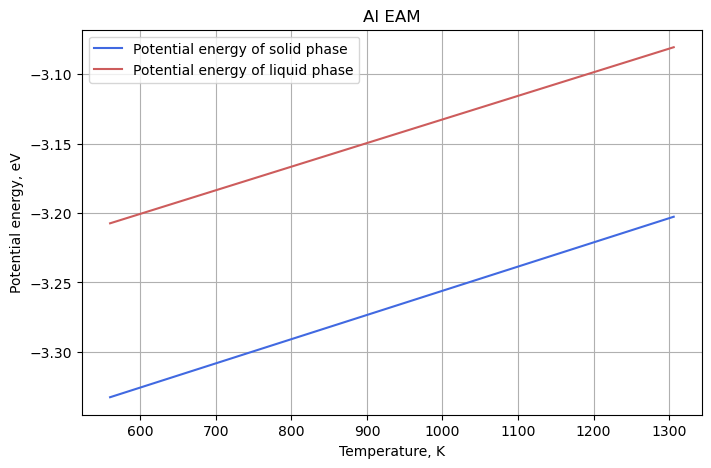

Temperatures of MD for the first L:
T1 = 896
T2 = 992
Results: L, T, number of solid outcomes, number of liquid outcomes
3 896 10 0
3 992 0 10
okay
MD data:
{3: {896: [10, 0], 992: [0, 10]}}
Desired accuracy: 1.0
L_train: [3]
N_train: [216.]
sigma_0: [3009.375]
T_train_dict: {3: 943.9999999997162}
sigma: {3: array([13.93229167])}
T_train: [944.]
var_temp: [15.09893203]
hyperparameters thN: 30.00000070023941 sig_f: 1075.7862086356572
T_inf = 934.9266317970873
delta_T_inf = 148.74687658280183


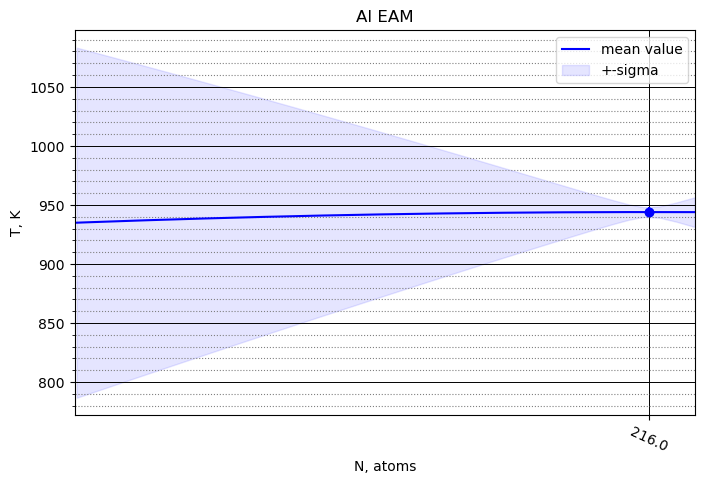

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [3.77954906e-04 9.58559807e+01 1.40746336e+02 1.45905855e+02
 1.38535148e+02 1.28092255e+02 1.17630089e+02 1.08064714e+02
 9.95881941e+01 9.21513221e+01]
L_next: 6
T_next: 937.0424815008615
Temperatures of MD for the next L:
T1: 935
T2: 939
Results: L, T, number of solid outcomes, number of liquid outcomes
6 935 0 1
6 939 0 1
low: 930 935
low: 926 930
okay
MD data:
{3: {896: [10, 0], 992: [0, 10]}, 6: {926: [1, 0], 930: [0, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3150.]
T_train_dict: {3: 943.999999997145, 6: 928.0000000000019}
sigma: {3: array([14.58333333]), 6: array([1.82291667])}
T_train: [944. 928.]
var_temp: [15.02215863  3.5022339 ]
hyperparameters thN: 4.143042710616907 sig_f: 987.2907074128307
T_inf = 926.0276705918129
delta_T_inf = 2.1800765789760765


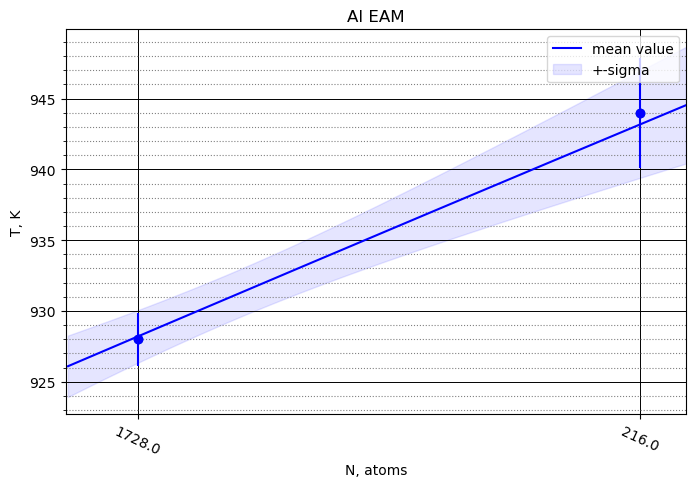

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [7.20643528e-06 2.79074505e-06 6.35501129e-06 1.65936533e-05
 7.34086313e-06 6.95329001e-06 6.47440070e-06 5.99919490e-06
 5.55983369e-06 5.16452067e-06]
L_next: 6
T_next: 928.0000000000019
Temperatures of MD for the next L:
T1: 926
T2: 930
Results: L, T, number of solid outcomes, number of liquid outcomes
6 926 0 1
6 930 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10]}, 6: {926: [1, 1], 930: [0, 2]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 944.0000000000001, 6: 924.9281949178412}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [944.         924.92819492]
var_temp: [15.092886    2.69925091]
hyperparameters thN: 5.132647276746372 sig_f: 972.5546506388503
T_inf = 922.404847173831
delta_T_inf = 1.9419782777318986


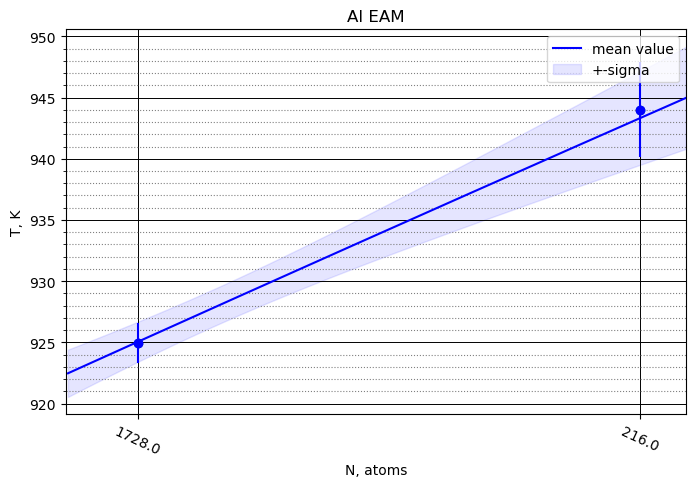

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [9.09117053e-06 1.41040060e-06 3.98933605e-06 1.08995137e-05
 4.90884754e-06 4.69127963e-06 4.39025254e-06 4.08064310e-06
 3.78944272e-06 3.52486689e-06]
L_next: 6
T_next: 924.9281949178412
Temperatures of MD for the next L:
T1: 923
T2: 926
Results: L, T, number of solid outcomes, number of liquid outcomes
6 923 0 1
6 926 1 0
MD data:
{3: {896: [10, 0], 992: [0, 10]}, 6: {926: [2, 1], 930: [0, 2], 923: [0, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 943.999999997773, 6: 924.9084992851883}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [944.         924.90849929]
var_temp: [15.09288593  1.90187352]
hyperparameters thN: 5.143809690785601 sig_f: 972.3872636042354
T_inf = 922.341740450861
delta_T_inf = 1.658441136855795


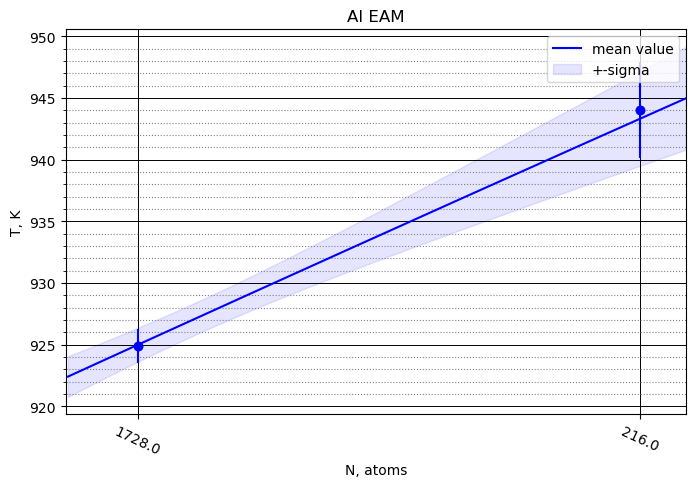

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [9.39385093e-06 4.27812726e-07 1.84793270e-06 5.43180868e-06
 2.51494341e-06 2.43622186e-06 2.29725775e-06 2.14517855e-06
 1.99811281e-06 1.86242718e-06]
L_next: 3
T_next: 943.999999997773
Temperatures of MD for the next L:
T1: 928
T2: 960
Results: L, T, number of solid outcomes, number of liquid outcomes
3 928 8 2
3 960 3 7
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [8, 2], 960: [3, 7]}, 6: {926: [2, 1], 930: [0, 2], 923: [0, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 947.269040848022, 6: 924.9084996031241}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [947.26904085 924.9084996 ]
var_temp: [6.75920014 1.90187093]
hyperparameters thN: 6.242533961978222 sig_f: 961.9143711561508
T_inf = 921.7823362080201
delta_T_inf = 1.6156646796505907


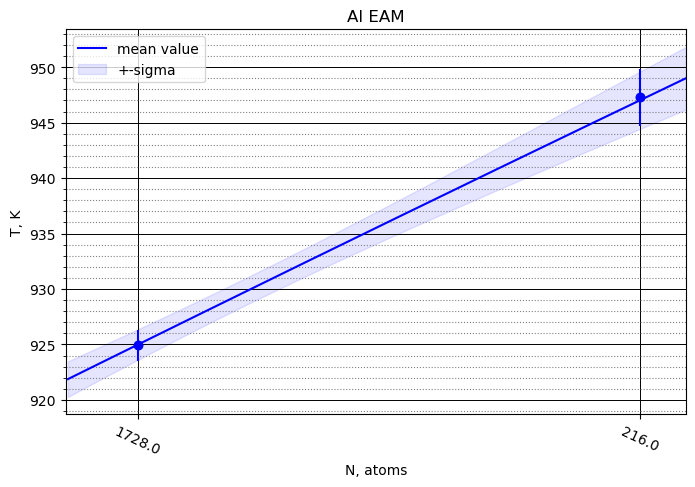

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [2.02561619e-06 9.56247179e-07 2.11102128e-06 5.47869208e-06
 2.41827328e-06 2.28813898e-06 2.12929053e-06 1.97230144e-06
 1.82743610e-06 1.69723818e-06]
L_next: 6
T_next: 924.9084996031241
Temperatures of MD for the next L:
T1: 923
T2: 926
Results: L, T, number of solid outcomes, number of liquid outcomes
6 923 1 0
6 926 1 0
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [8, 2], 960: [3, 7]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3187.5]
T_train_dict: {3: 947.2840930709746, 6: 926.1811422605688}
sigma: {3: array([14.75694444]), 6: array([1.84461806])}
T_train: [947.28409307 926.18114226]
var_temp: [6.95094501 1.59333899]
hyperparameters thN: 5.82608741375551 sig_f: 967.1151350349276
T_inf = 923.2361906954575
delta_T_inf = 1.4871658851307268


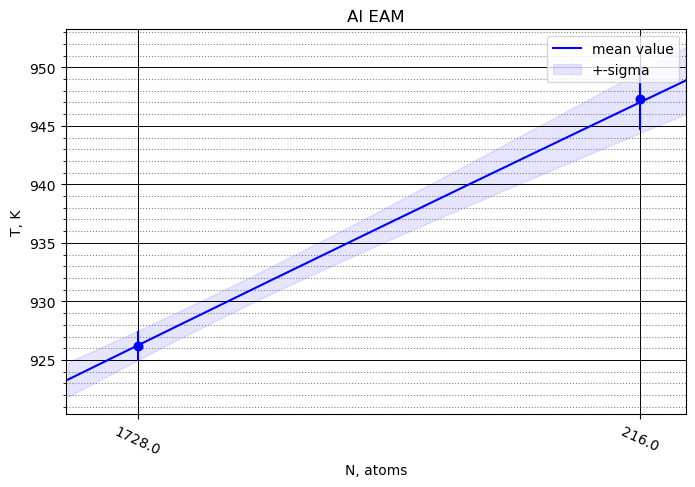

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.91900335e-06 5.27145566e-07 1.29756569e-06 3.44848366e-06
 1.53658759e-06 1.46076872e-06 1.36299238e-06 1.26457599e-06
 1.17294917e-06 1.09017805e-06]
L_next: 6
T_next: 926.1811422605688
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [8, 2], 960: [3, 7]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [1, 0], 928: [0, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 947.2690408479492, 6: 926.1344314905913}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [947.26904085 926.13443149]
var_temp: [6.75920013 1.3467375 ]
hyperparameters thN: 5.83892606378203 sig_f: 966.9369517948365
T_inf = 923.1724146995475
delta_T_inf = 1.3743589059247816


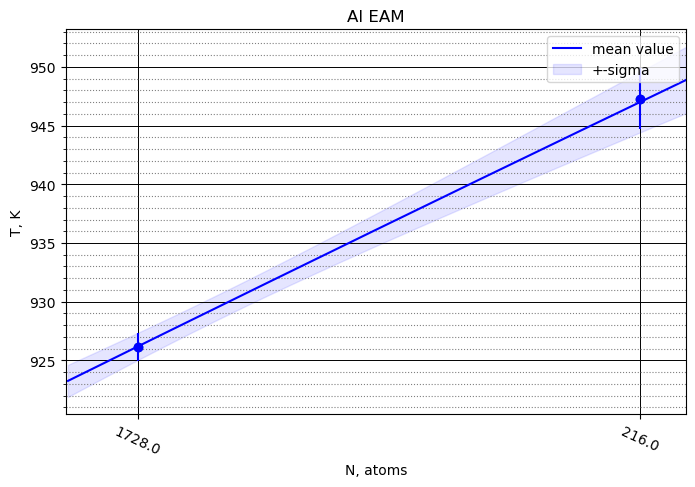

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [2.04079088e-06 3.72138751e-07 1.01323051e-06 2.74968325e-06
 1.23534217e-06 1.17920980e-06 1.10283303e-06 1.02466071e-06
 9.51301113e-07 8.84731974e-07]
L_next: 6
T_next: 926.1344314905913
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [8, 2], 960: [3, 7]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [2, 0], 928: [0, 2]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3150.]
T_train_dict: {3: 947.2803984297353, 6: 926.1128094241378}
sigma: {3: array([14.58333333]), 6: array([1.82291667])}
T_train: [947.28039843 926.11280942]
var_temp: [6.90858035 1.25961734]
hyperparameters thN: 5.849369564954237 sig_f: 966.8099247035789
T_inf = 923.1427039031797
delta_T_inf = 1.333762200824212


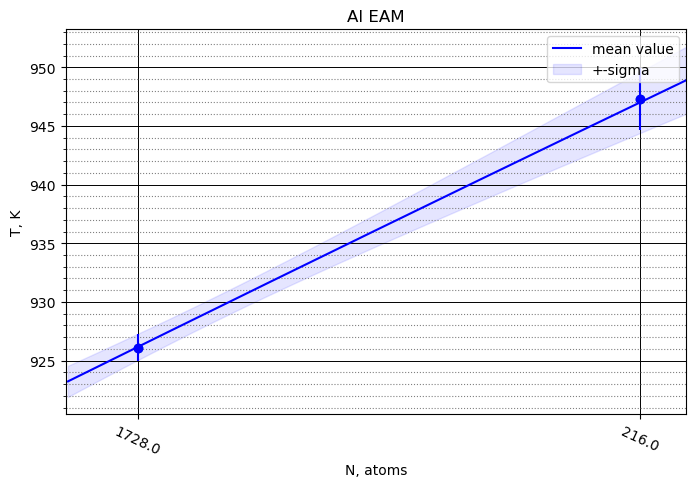

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.96264097e-06 2.73514974e-07 8.02454280e-07 2.20979444e-06
 9.98450413e-07 9.55767683e-07 8.95282459e-07 8.32632085e-07
 7.73511006e-07 7.19694250e-07]
L_next: 6
T_next: 926.1128094241378
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [8, 2], 960: [3, 7]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [3, 0], 928: [0, 3]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 947.2690408478297, 6: 926.0917961166612}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [947.26904085 926.09179612]
var_temp: [6.75920008 1.12152965]
hyperparameters thN: 5.854141369352011 sig_f: 966.7395305574238
T_inf = 923.1131550289072
delta_T_inf = 1.2637729660075494


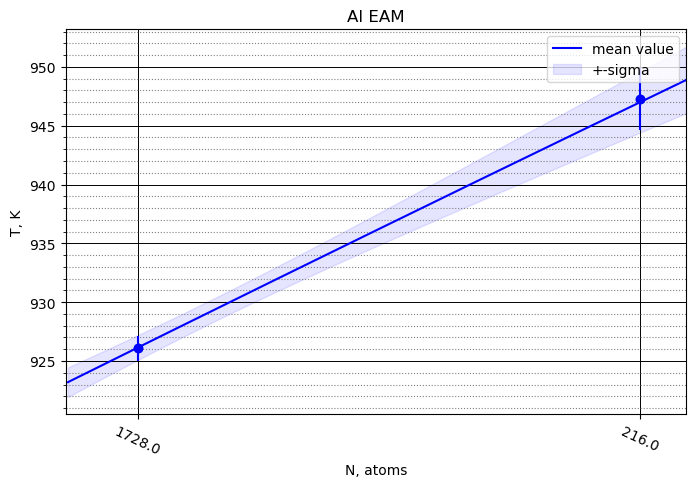

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [2.05567194e-06 2.11318896e-07 6.81030865e-07 1.90863718e-06
 8.68225247e-07 8.33882008e-07 7.82575708e-07 7.28648919e-07
 6.77417663e-07 6.30607982e-07]
L_next: 3
T_next: 947.2690408478297
Temperatures of MD for the next L:
T1: 928
T2: 960
Results: L, T, number of solid outcomes, number of liquid outcomes
3 928 7 3
3 960 1 9
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [15, 5], 960: [4, 16]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [3, 0], 928: [0, 3]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 942.2330729174953, 6: 926.0917961280093}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [942.23307292 926.09179613]
var_temp: [4.96432926 1.12153258]
hyperparameters thN: 4.286643035261195 sig_f: 983.4549608815969
T_inf = 923.8708166006471
delta_T_inf = 1.2465764028124784


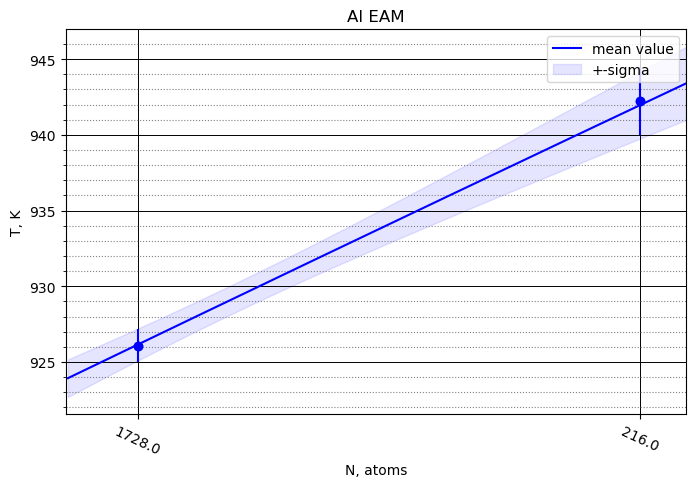

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.06970006e-06 2.91269903e-07 7.15709825e-07 1.90044198e-06
 8.46419524e-07 8.04447601e-07 7.50484613e-07 6.96225262e-07
 6.45735835e-07 6.00140424e-07]
L_next: 6
T_next: 926.0917961280093
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [15, 5], 960: [4, 16]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [4, 0], 928: [0, 4]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3150.]
T_train_dict: {3: 942.2142837696654, 6: 926.0819812209365}
sigma: {3: array([14.58333333]), 6: array([1.82291667])}
T_train: [942.21428377 926.08198122]
var_temp: [5.10178346 1.0793201 ]
hyperparameters thN: 4.283284521287776 sig_f: 983.4797585304839
T_inf = 923.8608658421542
delta_T_inf = 1.225555802493424


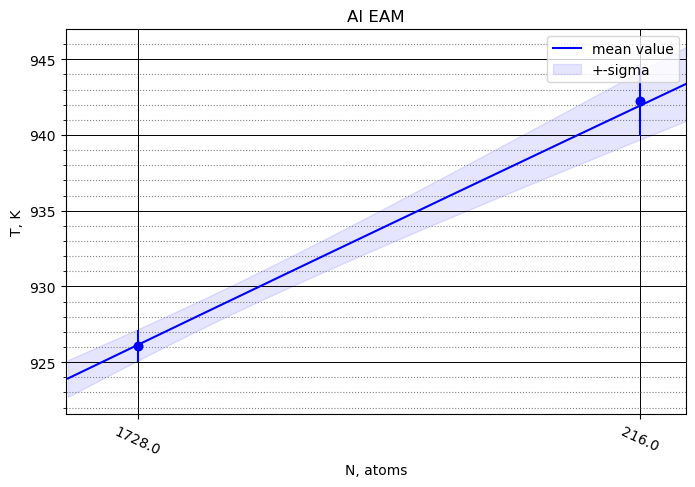

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.03891924e-06 2.35160238e-07 6.03365460e-07 1.61671128e-06
 7.22628472e-07 6.88017399e-07 6.42510514e-07 5.96426146e-07
 5.53397102e-07 5.14463250e-07]
L_next: 6
T_next: 926.0819812209365
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [15, 5], 960: [4, 16]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [5, 0], 928: [0, 5]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3000.]
T_train_dict: {3: 942.2356287521553, 6: 926.0692367909694}
sigma: {3: array([13.88888889]), 6: array([1.73611111])}
T_train: [942.23562875 926.06923679]
var_temp: [4.94166219 0.97708437]
hyperparameters thN: 4.295614681846077 sig_f: 983.3164484957704
T_inf = 923.8353592079181
delta_T_inf = 1.1692022685139003


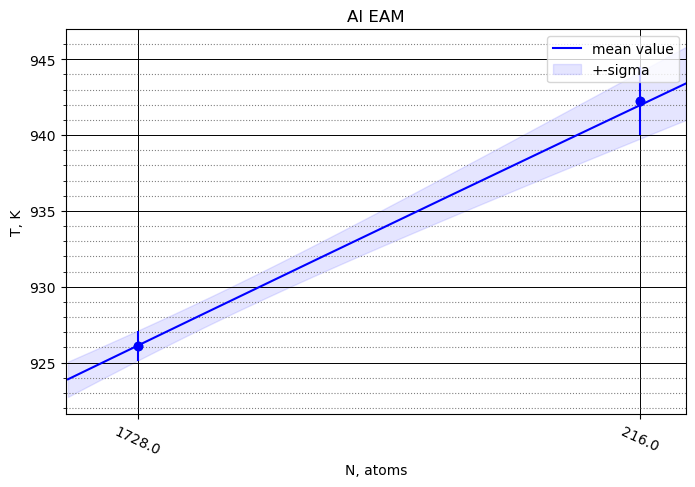

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.08249103e-06 1.99866667e-07 5.39923966e-07 1.46202602e-06
 6.56191783e-07 6.26045493e-07 5.85315524e-07 5.43720447e-07
 5.04728090e-07 4.69366941e-07]
L_next: 6
T_next: 926.0692367909694
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 1 0
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [15, 5], 960: [4, 16]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [6, 0], 928: [1, 5]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 942.2330589943082, 6: 926.5584388075073}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [942.23305899 926.55843881]
var_temp: [4.96844059 0.93463128]
hyperparameters thN: 4.14367375274373 sig_f: 985.7039554327326
T_inf = 924.3974179941063
delta_T_inf = 1.1453400217745575


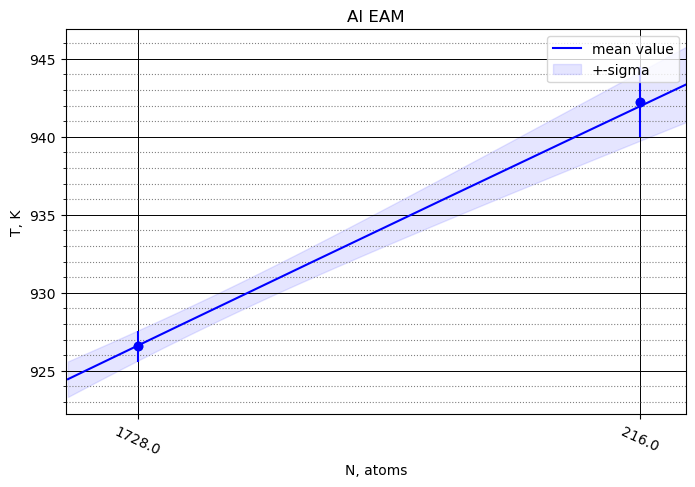

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.07667246e-06 1.72599528e-07 4.84098814e-07 1.32058496e-06
 5.94410710e-07 5.67906009e-07 5.31382015e-07 4.93861011e-07
 4.58590213e-07 4.26554011e-07]
L_next: 6
T_next: 926.5584388075073
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [15, 5], 960: [4, 16]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [7, 0], 928: [1, 6]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3150.]
T_train_dict: {3: 942.2143050139865, 6: 926.5171119220937}
sigma: {3: array([14.58333333]), 6: array([1.82291667])}
T_train: [942.21430501 926.51711192]
var_temp: [5.0960491  0.91749684]
hyperparameters thN: 4.1499177292360985 sig_f: 985.5781918134211
T_inf = 924.3525808159629
delta_T_inf = 1.1367002486496276


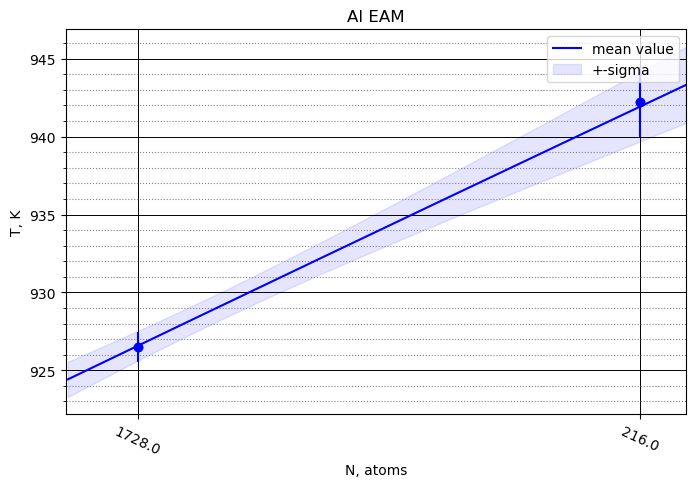

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.04063697e-06 1.46088557e-07 4.25367014e-07 1.16881779e-06
 5.27578577e-07 5.04753832e-07 4.72660712e-07 4.39496646e-07
 4.08235893e-07 3.79798167e-07]
L_next: 6
T_next: 926.5171119220937
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 1 0
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [15, 5], 960: [4, 16]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [8, 0], 928: [2, 6]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3018.75]
T_train_dict: {3: 942.2330613221412, 6: 926.8764447702309}
sigma: {3: array([13.97569444]), 6: array([1.74696181])}
T_train: [942.23306132 926.87644477]
var_temp: [4.96778443 0.85616469]
hyperparameters thN: 4.046498271524196 sig_f: 987.257647400776
T_inf = 924.7590584309686
delta_T_inf = 1.0999448629818889


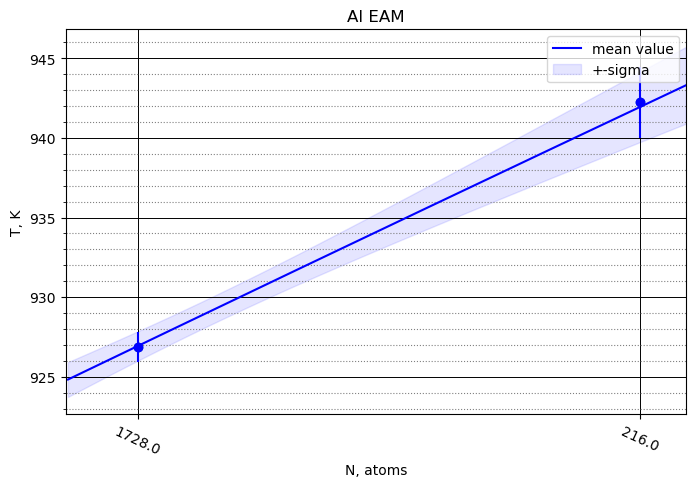

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.07720572e-06 1.32123259e-07 4.00309765e-07 1.10825925e-06
 5.01691221e-07 4.80669864e-07 4.50468375e-07 4.19066803e-07
 3.89383415e-07 3.62337727e-07]
L_next: 6
T_next: 926.8764447702309
Temperatures of MD for the next L:
T1: 925
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 925 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [15, 5], 960: [4, 16]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [8, 0], 928: [2, 7], 925: [1, 0]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3150.]
T_train_dict: {3: 942.214299828805, 6: 926.8600200267065}
sigma: {3: array([14.58333333]), 6: array([1.82291667])}
T_train: [942.21429983 926.86002003]
var_temp: [5.0974548  0.84307429]
hyperparameters thN: 4.045000454807045 sig_f: 987.2545510729805
T_inf = 924.7432167331873
delta_T_inf = 1.0933335636524295


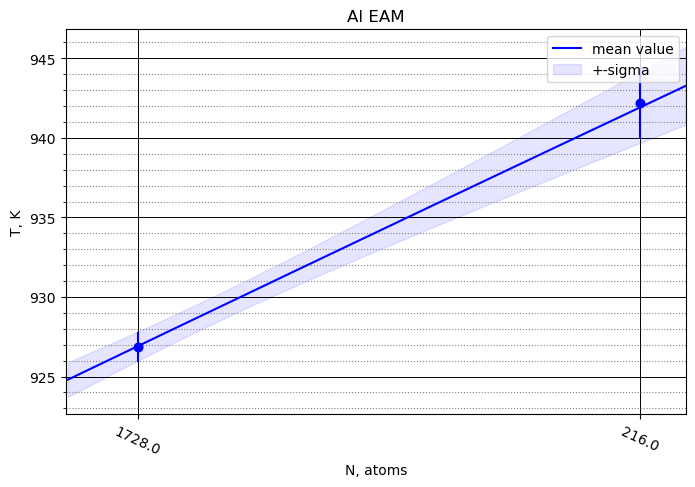

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [1.04139756e-06 1.12192504e-07 3.53844175e-07 9.86915866e-07
 4.48033109e-07 4.29860684e-07 4.03168343e-07 3.75244523e-07
 3.48774360e-07 3.24618539e-07]
L_next: 3
T_next: 942.214299828805
Temperatures of MD for the next L:
T1: 928
T2: 960
Results: L, T, number of solid outcomes, number of liquid outcomes
3 928 7 3
3 960 2 8
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [22, 8], 960: [6, 24]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [8, 0], 928: [2, 7], 925: [1, 0]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3000.]
T_train_dict: {3: 941.5864049981524, 6: 926.8389364048967}
sigma: {3: array([13.88888889]), 6: array([1.73611111])}
T_train: [941.586405  926.8389364]
var_temp: [4.09307713 0.8120982 ]
hyperparameters thN: 3.8709219551159615 sig_f: 989.4336475175506
T_inf = 924.8042568754769
delta_T_inf = 1.0656723452860335


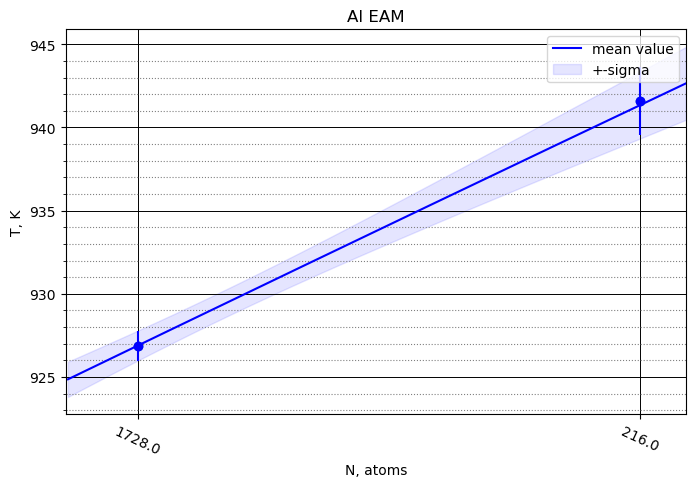

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [7.42025260e-07 1.38710266e-07 3.73268508e-07 1.00987959e-06
 4.53097097e-07 4.32203065e-07 4.04042376e-07 3.75305198e-07
 3.48375853e-07 3.23959332e-07]
L_next: 6
T_next: 926.8389364048967
Temperatures of MD for the next L:
T1: 925
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 925 0 1
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [22, 8], 960: [6, 24]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [8, 0], 928: [2, 8], 925: [1, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3150.]
T_train_dict: {3: 938.0565642006907, 6: 926.4749403834846}
sigma: {3: array([14.58333333]), 6: array([1.82291667])}
T_train: [938.0565642  926.47494038]
var_temp: [3.50081092 0.80177667]
hyperparameters thN: 2.9504349821882987 sig_f: 1001.5346788030078
T_inf = 924.9205842610248
delta_T_inf = 1.0513406606889972


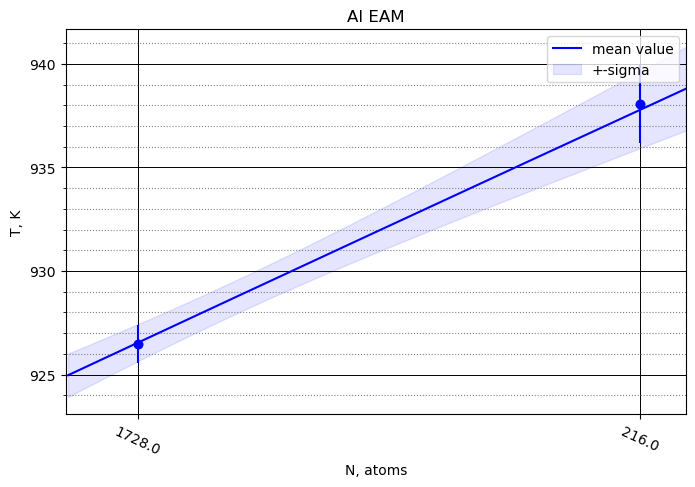

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [4.67909451e-07 1.39807803e-07 3.35915932e-07 8.87477256e-07
 3.94454321e-07 3.74504933e-07 3.49175563e-07 3.23811641e-07
 3.00257046e-07 2.79010015e-07]
L_next: 6
T_next: 926.4749403834846
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [22, 8], 960: [6, 24]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [9, 0], 928: [2, 9], 925: [1, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3000.]
T_train_dict: {3: 941.5864071487694, 6: 926.4332782752695}
sigma: {3: array([13.88888889]), 6: array([1.73611111])}
T_train: [941.58640715 926.43327828]
var_temp: [4.09261183 0.74549752]
hyperparameters thN: 3.9950417725149503 sig_f: 987.4044280035498
T_inf = 924.332321129508
delta_T_inf = 1.0247669499129264


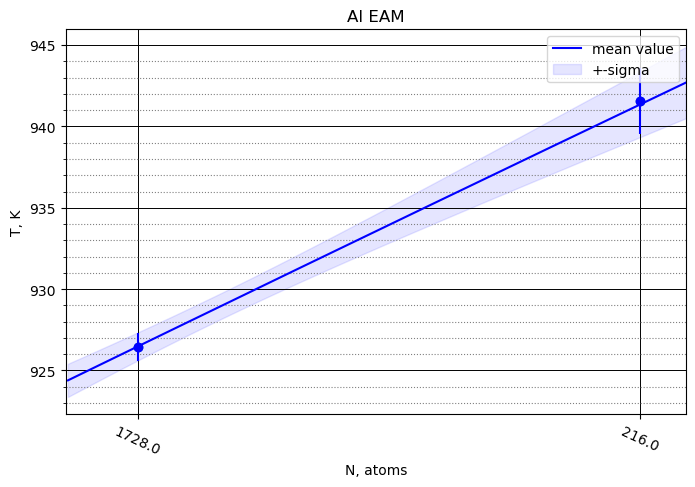

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [7.48791578e-07 1.07166799e-07 3.10371911e-07 8.51983876e-07
 3.84420669e-07 3.67721110e-07 3.44304977e-07 3.20126621e-07
 2.97344222e-07 2.76623451e-07]
L_next: 6
T_next: 926.4332782752695
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [22, 8], 960: [6, 24]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [10, 0], 928: [2, 10], 925: [1, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3150.]
T_train_dict: {3: 938.2419710960228, 6: 926.4147100933258}
sigma: {3: array([14.58333333]), 6: array([1.82291667])}
T_train: [938.2419711  926.41471009]
var_temp: [3.32189189 0.74871936]
hyperparameters thN: 3.0236086098202497 sig_f: 1000.4111185387163
T_inf = 924.8156099673083
delta_T_inf = 1.0171104929014152


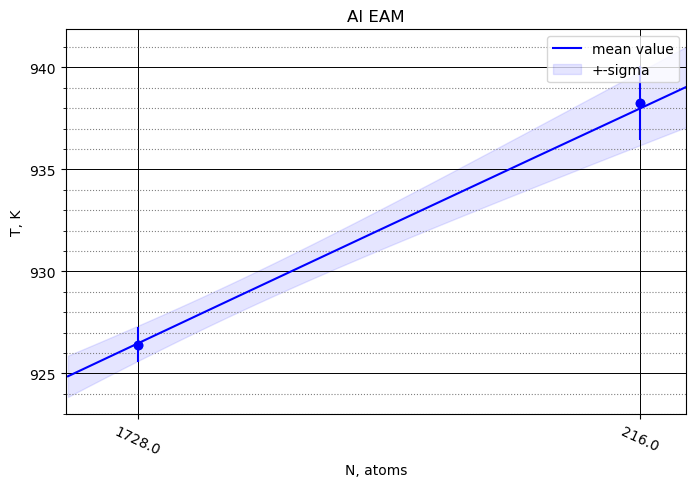

L_array: [ 3  4  5  6  7  8  9 10 11 12]
dVar_defforts [4.27467364e-07 1.20113596e-07 2.92567540e-07 7.75233525e-07
 3.44969956e-07 3.27715262e-07 3.05652038e-07 2.83507628e-07
 2.62919923e-07 2.44337251e-07]
L_next: 6
T_next: 926.4147100933258
Temperatures of MD for the next L:
T1: 924
T2: 928
Results: L, T, number of solid outcomes, number of liquid outcomes
6 924 1 0
6 928 0 1
MD data:
{3: {896: [10, 0], 992: [0, 10], 928: [22, 8], 960: [6, 24]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [11, 0], 928: [2, 11], 925: [1, 1]}}
L_train: [3 6]
N_train: [ 216. 1728.]
sigma_0: [3000.]
T_train_dict: {3: 941.5864097016425, 6: 926.3817981385686}
sigma: {3: array([13.88888889]), 6: array([1.73611111])}
T_train: [941.5864097  926.38179814]
var_temp: [4.09205472 0.69940108]
hyperparameters thN: 4.011135096510686 sig_f: 987.1432242228838
T_inf = 924.2699747723235
delta_T_inf = 0.995273389948036


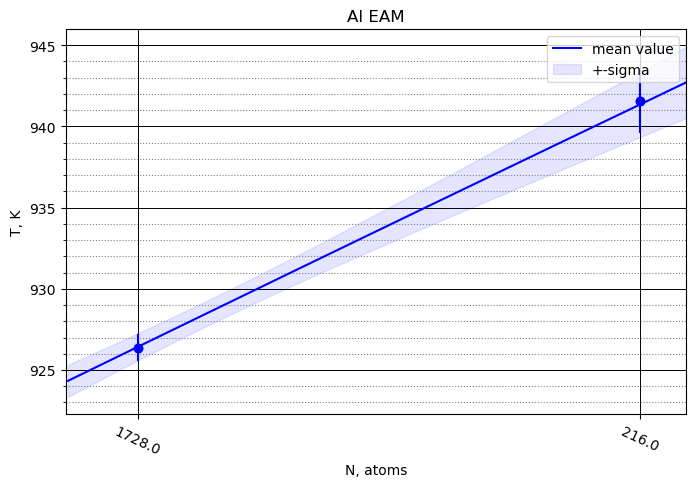

{3: {896: [10, 0], 992: [0, 10], 928: [22, 8], 960: [6, 24]}, 6: {926: [3, 1], 930: [0, 2], 923: [1, 1], 924: [11, 0], 928: [2, 11], 925: [1, 1]}}
T_inf = 924.2699747723235
Var_T_inf = 0.995273389948036
2020.9549 seconds


In [7]:
Alum.MainFunc('Al_0707.csv')